# Task 3 model implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model import Model, Optimizer, NetworkModification, TransitScheduleModification

Creating a model implementation only requires pointing to a folder with all the necessary input data. Here, we have a region with 4 microtypes and four modes (walk, bus, auto, and rail), with rail only service two of the four microtypes

Once the model is created, you find supply/demand equilibrium and gather statistics such as mode splits, speeds, and user costs for an individual time period or for the whole day.

In [2]:
model = Model("input-data")

userCosts, operatorCosts = model.collectAllCosts()
modeSplit = model.getModeSplit('AM-Peak')
speeds = model.getModeSpeeds('AM-Peak')
print(modeSplit)
print(speeds)
print("Total user costs =", userCosts.total)

['bus: 0.052142591417491786', 'walk: 0.02160401702838168', 'rail: 0.3002508788784096', 'auto: 0.6260025126757168']
              A          B         C          D
bus    7.583612   6.609923  6.708781   8.137865
walk   1.400000   1.400000  1.400000   1.400000
rail  15.000000        NaN       NaN  20.000000
auto  11.704070  10.227063  9.006079   9.806835
Total user costs = 142723.94205726232


Once a model is created, there are a set of objects and methods that make it easy to modify the transportation system without needing to change the original input files.

Here, we will devote some road space to dedicated bus lanes. In particular, we are transitioning 1000 lane-meters of roadway from mixed bus/car traffic to bus-only lanes in microtypes A and B:

In [3]:
networkModification = NetworkModification(np.array([1000., 1000.]), list(zip([2, 4], [13, 14])))
model.modifyNetworks(networkModification = networkModification)

Once these changes are made, we can re-equilibrate the model and look at how metrics have changed. Here, we have (slightly) increased the bus mode share, in large part by increasing average bus speed in Microtypes A and B. However, because we have decreased auto speeds in these two microtypes, total user costs have gone up.

In [4]:
userCosts, operatorCosts = model.collectAllCosts()
modeSplit = model.getModeSplit('AM-Peak')
speeds = model.getModeSpeeds('AM-Peak')
print(modeSplit)
print(speeds)
print("Total user costs =", userCosts.total)

['bus: 0.0584514613570315', 'walk: 0.021571581608894795', 'rail: 0.30042240870551984', 'auto: 0.6195545483285535']
              A         B         C          D
bus    7.764350  7.281306  6.718741   8.125752
walk   1.400000  1.400000  1.400000   1.400000
rail  15.000000       NaN       NaN  20.000000
auto  11.640535  9.625910  9.082246   9.829107
Total user costs = 143492.70881933466


You can also modify the headways for the different transit modes. Here, we can decrease the headway of the bus mode in Microtype A to 200 seconds.

In [5]:
scheduleModification = TransitScheduleModification([200.0], [("A", "bus")])
model.modifyNetworks(scheduleModification = scheduleModification)
userCosts, operatorCosts = model.collectAllCosts()
modeSplit = model.getModeSplit('AM-Peak')
speeds = model.getModeSpeeds('AM-Peak')
print(modeSplit)
print(speeds)
print("Total user costs =", userCosts.total)

['walk: 0.021035088065648428', 'bus: 0.06481824119039714', 'rail: 0.297956955291959', 'auto: 0.6161897154519953']
              A         B         C          D
walk   1.400000  1.400000  1.400000   1.400000
bus    7.858935  7.207189  6.673951   8.120800
rail  15.000000       NaN       NaN  20.000000
auto  11.609338  9.660573  9.115923   9.834625
Total user costs = 143431.92451870034


Here, we can see that the bus mode share went up (because of lower wait times). In addition, bus speeds in microtype A increased because there was less crowding on each bus, but bus speeds slightly decreased in the other microtypes because of the increase in bus ridership without a corresponding decrease in headways.

## Optimization wrapper

In order to run optimization on the model, we can create an "Optimizer" object that contains a model implementation as well as a direct pathway to modifying model parameters.



In [6]:
networksToReallocate = list(zip([2, 4, 6, 8], [13, 14, 15, 16]))
modesToModify = list(zip(["A", "B", "C", "D"], ["bus", "bus", "bus", "bus"]))
    
o = Optimizer("input-data",fromToSubNetworkIDs= networksToReallocate,
                  modesAndMicrotypes= modesToModify,
                  method="noisy")
default = o.x0()

Done


Once this model is initialized, we can evaluate the total costs in the base, unmodified state

In [7]:
o.evaluate(default)

[ 10.  10.  10.  10. 300. 300. 300. 300.]
132661.86760340078


132661.86760340078

Looking in the optimizer, we can get the state of the transportation system given the input control variable

In [8]:
modeSplit = o.model.getModeSplit('AM-Peak')
speeds = o.model.getModeSpeeds('AM-Peak')
print(modeSplit)
print(speeds)

['walk: 0.019957084426933676', 'bus: 0.07154931630091255', 'rail: 0.2997331140149221', 'auto: 0.6087604852572313']
              A          B         C          D
walk   1.400000   1.400000  1.400000   1.400000
bus    7.476484   6.974895  7.029347   8.181203
rail  15.000000        NaN       NaN  20.000000
auto  11.731405  10.316649  9.099427   9.788432


We can use this to look at the model performance under a range of inputs. Here we vary headway for buses in microtype A

[ 10.  10.  10.  10. 180. 300. 300. 300.]
135096.15378874243
[ 10.  10.  10.  10. 240. 300. 300. 300.]
133312.7980375025
[ 10.  10.  10.  10. 300. 300. 300. 300.]
132596.5910355034
[ 10.  10.  10.  10. 360. 300. 300. 300.]
132357.44712416598
[ 10.  10.  10.  10. 420. 300. 300. 300.]
132363.9609248653
[ 10.  10.  10.  10. 480. 300. 300. 300.]
132503.77897674165
[ 10.  10.  10.  10. 540. 300. 300. 300.]
132717.70710533936
[ 10.  10.  10.  10. 600. 300. 300. 300.]
132972.28302545712
[ 10.  10.  10.  10. 660. 300. 300. 300.]
133247.41555888316
[ 10.  10.  10.  10. 720. 300. 300. 300.]
133531.5387460912
[ 10.  10.  10.  10. 780. 300. 300. 300.]
133817.0503763516
[ 10.  10.  10.  10. 840. 300. 300. 300.]
134099.17150535737
[ 10.  10.  10.  10. 900. 300. 300. 300.]
134375.43031965275
[ 10.  10.  10.  10. 960. 300. 300. 300.]
134643.3202367464
[  10.   10.   10.   10. 1020.  300.  300.  300.]
134901.93635947353
[  10.   10.   10.   10. 1080.  300.  300.  300.]
135152.0850364584
[  10.   10.   

Text(0, 0.5, 'Total Cost')

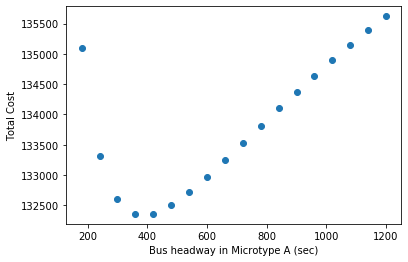

In [9]:
    busHeadwayA = np.arange(180, 1260, 60)
    speeds = dict()
    modeSplits = dict()
    totalCost = []
    for hw in busHeadwayA:
        default[4] = hw
        cost = o.evaluate(default)
        totalCost.append(cost)
        speeds[str(hw)] = o.model.getModeSpeeds('AM-Peak').stack()
        modeSplits[str(hw)] = pd.Series(o.model.getModeSplit('AM-Peak').toDict())
        
    speeds = pd.DataFrame(speeds).transpose()
    modeSplits = pd.DataFrame(modeSplits).transpose()
    
    plt.scatter(busHeadwayA, totalCost)
    plt.xlabel("Bus headway in Microtype A (sec)")
    plt.ylabel("Total Cost")

We can plot mode splits and speeds in the different microtypes

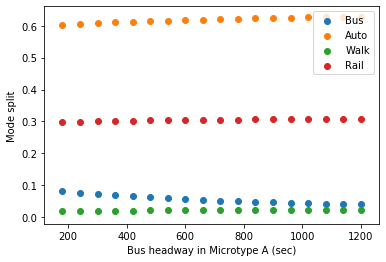

In [10]:
plt.scatter(busHeadwayA, modeSplits["bus"], label="Bus")
plt.scatter(busHeadwayA, modeSplits["auto"], label="Auto")
plt.scatter(busHeadwayA, modeSplits["walk"], label="Walk")
plt.scatter(busHeadwayA, modeSplits["rail"], label="Rail")
plt.xlabel("Bus headway in Microtype A (sec)")
plt.ylabel("Mode split")
plt.legend()

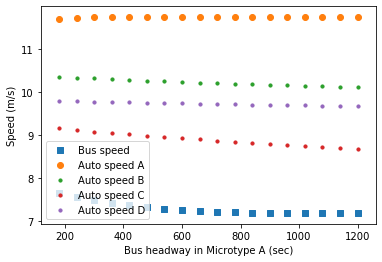

In [11]:
plt.scatter(busHeadwayA, speeds[("bus", "A")], marker='s', label="Bus speed")
plt.scatter(busHeadwayA, speeds[("auto", "A")], label="Auto speed A")
plt.scatter(busHeadwayA, speeds[("auto", "B")], label="Auto speed B", s=10)
plt.scatter(busHeadwayA, speeds[("auto", "C")], label="Auto speed C", s=10)
plt.scatter(busHeadwayA, speeds[("auto", "D")], label="Auto speed D", s=10)
plt.xlabel("Bus headway in Microtype A (sec)")
plt.ylabel("Speed (m/s)")
plt.legend()

We can also vary lane dedication (this is still a little wonky)

[  0.  10.  10.  10. 300. 300. 300. 300.]
132215.59240969544
[100.  10.  10.  10. 300. 300. 300. 300.]
132193.68120576112
[200.  10.  10.  10. 300. 300. 300. 300.]
132123.82074605062
[300.  10.  10.  10. 300. 300. 300. 300.]
132004.22461376622
[400.  10.  10.  10. 300. 300. 300. 300.]
131832.38185990963
[500.  10.  10.  10. 300. 300. 300. 300.]
131601.44826275413
[600.  10.  10.  10. 300. 300. 300. 300.]
131303.31290713415
[700.  10.  10.  10. 300. 300. 300. 300.]
130924.94021434711
[800.  10.  10.  10. 300. 300. 300. 300.]
130444.37127931659
[900.  10.  10.  10. 300. 300. 300. 300.]
129817.62282105566


Text(0, 0.5, 'Total Cost')

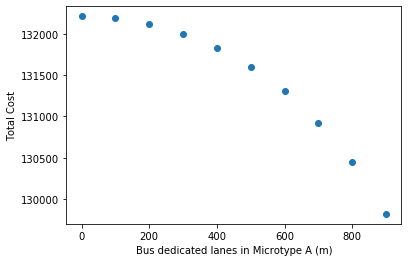

In [12]:
    default = o.x0()
    laneDedication = np.arange(0, 1000, 100)
    speeds = dict()
    modeSplits = dict()
    totalCost = []
    for ded in laneDedication:
        default[0] = ded
        cost = o.evaluate(default)
        totalCost.append(cost)
        speeds[str(ded)] = o.model.getModeSpeeds('AM-Peak').stack()
        modeSplits[str(ded)] = pd.Series(o.model.getModeSplit('AM-Peak').toDict())
        
    speeds = pd.DataFrame(speeds).transpose()
    modeSplits = pd.DataFrame(modeSplits).transpose()
    
    
    plt.scatter(laneDedication, totalCost)
    plt.xlabel("Bus dedicated lanes in Microtype A (m)")
    plt.ylabel("Total Cost")

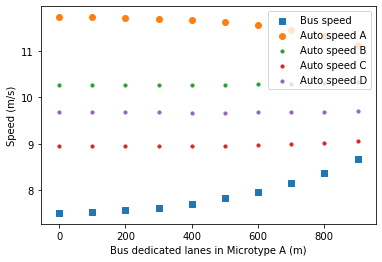

In [13]:
plt.scatter(laneDedication, speeds[("bus", "A")], marker='s', label="Bus speed")
plt.scatter(laneDedication, speeds[("auto", "A")], label="Auto speed A")
plt.scatter(laneDedication, speeds[("auto", "B")], label="Auto speed B", s=10)
plt.scatter(laneDedication, speeds[("auto", "C")], label="Auto speed C", s=10)
plt.scatter(laneDedication, speeds[("auto", "D")], label="Auto speed D", s=10)
plt.xlabel("Bus dedicated lanes in Microtype A (m)")
plt.ylabel("Speed (m/s)")
plt.legend()